# Binary Classification Results Evaluation

In [ ]:
from pathlib import Path
import seaborn as sn
import os
import sys
sys.path.append(str(Path.cwd().parent))
from src.utils.gcs_utils import set_environement_variable
from sklearn.linear_model import LinearRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

is_env_variables_set = set_environement_variable()
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'path to auth.json file'

from src.utils import envs 
e=envs.Envs()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1.  Read Test Predictions

In [139]:
#df_preds = pd.read_csv('gs://oro-ds-test-bucket/sdd_acne_files/mlflow_prod/3a996e334b794ccfa60bb110e63e0be2/artifacts/files/bit-ResNetV2-test_predictions.csv')
df_preds= pd.read_csv('bit-5-test_predictions.csv')
print(f'There are {df_preds.shape[0]} images in the test set.')
df_preds.head()

There are 1209 images in the test set.


,prob_acne,prob_not_acne,filename,label,predicted,preds
0,0.000297,9.997033e-01,resized/13434/09CBF5519C/ailment_photos/AP-a0a...,not_acne,not_acne,1
1,1.000000,2.358981e-09,resized/18110/B0403BD7DA/ailment_photos/AP-4b2...,acne,acne,0
2,0.997596,2.404374e-03,resized/11743/DDBE4149CB/ailment_photos/AP-f72...,acne,acne,0
3,1.000000,1.111982e-08,resized/12173/443392F288/ailment_photos/AP-29e...,acne,acne,0
4,0.000003,9.999974e-01,resized/14964/8A1D4DFAFE/files/BCAEDC678E64453...,not_acne,not_acne,1


In [140]:
df_preds['label'].value_counts()

not_acne    609
acne        600
Name: label, dtype: int64

In [141]:
#df_dataset = pd.read_csv('bit-dataset.csv')
df_dataset = pd.read_csv('gs://oro-ds-test-bucket/shanel_test/raw_image_paths_from_db.csv')
df_dataset.rename(columns={'pathBucketImage':'filename'}, inplace=True)
df_dataset['filename'] = 'resized/' + df_dataset['filename'].astype(str)
df_dataset.head()

,Unnamed: 0,filename,labelledby,reviewedby,acne_comedos,acne_cystic,acne_mixed,acne_scars,acne_excoriated,rosacea_erythemato_telangiectasique,...,keratosis_pilaris,molluscum,folliculitis,melanonychia,nevus,lichen_planus,chelitis_actinic,cheilitis_eczematous,urticaria,unspecified
0,0,resized/7830/646B3FD8EE/ailment_photos/AP-c1bb...,Guillemette Salomon,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1,resized/9369/005F4BC9BC/ailment_photos/AP-231d...,Guillemette Salomon,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,2,resized/936/E617F7DF5F/ailment_photos/AP-cc6f0...,Guillemette Salomon,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,3,resized/9716/7C41A121CF/ailment_photos/AP-5643...,Guillemette Salomon,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,4,resized/9718/BF893BCA47/ailment_photos/AP-0743...,Guillemette Salomon,NaN,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True


In [142]:
df_preds['acne'] =  df_preds['label']=='acne'

# 2. Merge Predictions with Disease Types

In [143]:
columns = ['rosacea_inflammatory','rosacea_erythemato_telangiectasique','peri_oral_dermatitis',
                'seborrheic_keratosis','psoriasis_vulgar','seborrheic_dermatitis','nummular_eczema',
                'tinea_versicolor','chronic_hand_eczema','vulgar_warts','folliculitis','alopecia_androgenic',
                'dyshidrosis','nevus','melasma','alopecia_areata','intertrigo','urticaria','vitiligo','keratosis_pilaris',
                'molluscum','cheilitis_eczematous','tinea_corporis','prurigo_nodularis','actinic_keratosis',
                'genital_warts','plane_warts','pityriasis_rosae','melanonychia','psoriasis_pustular_palmoplantar',
                'granuloma_annulare','psoriasis_guttate','lichen_simplex_chronicus','shingles','herpes_simplex', 'acne_cystic', 'acne_scars', 'acne_mixed', 'acne_excoriated', 'acne_comedos']

In [144]:
df_preds = df_preds.merge(df_dataset, how='left', on='filename')
df_preds['diseases'] = df_preds[columns].apply(lambda x: tuple(df_preds[columns].columns[np.argwhere(x.values== True).flatten()], ), axis=1)

# 3. Analysis of Misclassified Images

In [145]:
def get_performance_based_confidence(df_preds, label_coln= 'label', pred_coln= 'predicted', 
                                     prob_acne_coln='prob_acne', prob_not_acne_coln='prob_not_acne', 
                                     acne_confidence = 0.5, not_acne_confidence = 0.5):
    masks = (df_preds[prob_acne_coln] < acne_confidence) & (df_preds[prob_not_acne_coln] < not_acne_confidence)
    df_prob =  df_preds.copy()
    df_prob = df_prob[~masks]
    #print(df_preds[masks])
    print(f'test images discarded: {df_preds.shape[0]-df_prob.shape[0]}/{df_preds.shape[0]}')
    matrix = confusion_matrix(df_prob[label_coln], df_prob[pred_coln])
    index = ['acne', 'not_acne', ]
    df_cm = pd.DataFrame(matrix, index=index, columns=index)
    f = plt.figure()
    sn.heatmap(df_cm, annot=True, fmt='g')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    print(classification_report(df_prob[label_coln], df_prob[pred_coln], target_names=index, output_dict=False))
    return masks

test images discarded: 0/1209
              precision    recall  f1-score   support

        acne       0.95      0.91      0.93       600
    not_acne       0.91      0.95      0.93       609

    accuracy                           0.93      1209
   macro avg       0.93      0.93      0.93      1209
weighted avg       0.93      0.93      0.93      1209



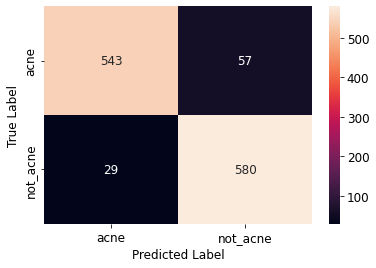

In [159]:
_ = get_performance_based_confidence(df_preds, acne_confidence = 0.5, not_acne_confidence = 0.5)

test images discarded: 91/1209
              precision    recall  f1-score   support

        acne       0.97      0.93      0.95       552
    not_acne       0.93      0.98      0.95       566

    accuracy                           0.95      1118
   macro avg       0.95      0.95      0.95      1118
weighted avg       0.95      0.95      0.95      1118



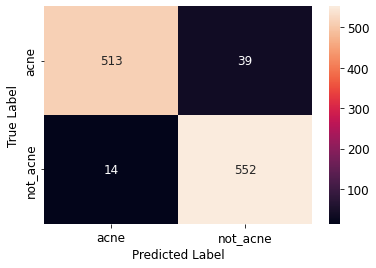

In [168]:
masks = get_performance_based_confidence(df_preds, acne_confidence = 0.9, not_acne_confidence = 0.9)

# 4. Calibration

In [148]:
df_preds['label_int']= df_preds['label'].map({'acne':1, 'not_acne':0})

In [149]:
def calibration_histogram(df_preds, label_coln, prob_coln, step_size = 0.02):
    defined_bins = np.arange(0, 1.01, step=step_size)

    # discretize the predicted probabilties [0, 1] interval into bins
    # pred_prob corresponds to probabilities of the positive class
    df_preds['bin_prob'] = pd.cut(x=df_preds[prob_coln], bins=defined_bins)

    def get_ratio(x):
        total_positives = x.sum()
        if total_positives==0:
            z = 0
        else:
            try:
                z = total_positives / x.size
            except:
                z = 0
        return z

    plt.rcParams.update({'font.size': 12})

    plt.figure(figsize=(10,6))
    plt.bar(x = defined_bins[:-1],
            height = df_preds.groupby('bin_prob')[label_coln].apply(lambda x: get_ratio(x)).values,
            width=step_size,
            label="Model calibration",
            edgecolor="white")

    # plt.plot(prob_true,prob_pred, label="RMFLP Model calibration")
    plt.plot(np.arange(0, 1.1, 0.1),np.arange(0, 1.1, 0.1) , linestyle="--", color='black', linewidth=3, label="Perfectly calibrated")
    plt.title("Calibration Histogram")
    plt.legend()
    plt.xlabel("Mean predicted value")
    plt.ylabel("Fraction of positives")
    plt.xlim(xmin=0)

    plt.tight_layout()
    plt.show()
    return defined_bins[:-1], df_preds.groupby('bin_prob')[label_coln].apply(lambda x: get_ratio(x)).values

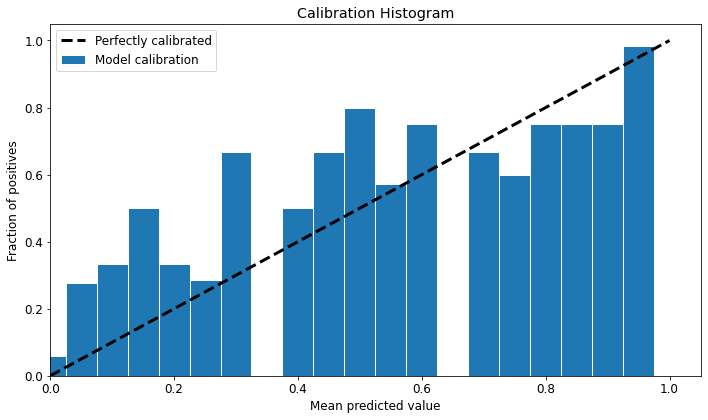

In [150]:
bins, probs = calibration_histogram(df_preds, 'label_int', 'prob_acne', step_size = 0.05)


### Calibration - Fit linear regression


In [151]:
reg = LinearRegression().fit(X=np.expand_dims(bins, axis=1), y=probs)

In [152]:
df_preds['calibrated_prob_acne'] = reg.predict(np.expand_dims(df_preds['prob_acne'], axis=1))

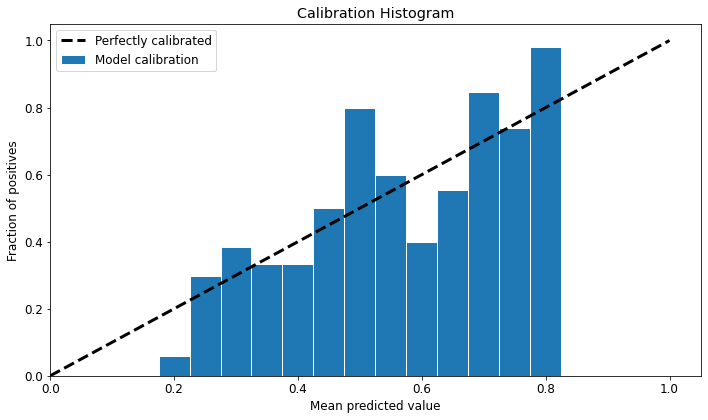

In [153]:
_, _ = calibration_histogram(df_preds, 'label_int', 'calibrated_prob_acne', step_size = 0.05)

In [154]:
df_preds['calibrated_prob_acne'] = df_preds['calibrated_prob_acne'].apply(lambda x: 0 if x <0 else (1 if x>1 else x))

In [155]:
df_preds['calibrated_prob_not_acne']= 1- df_preds['calibrated_prob_acne']

In [156]:
df_preds['calibrated_predicted'] = df_preds['calibrated_prob_acne'].apply(lambda x: 'acne' if x>0.5 else 'not_acne')

test images discarded: 0/1209
              precision    recall  f1-score   support

        acne       0.95      0.91      0.93       600
    not_acne       0.91      0.95      0.93       609

    accuracy                           0.93      1209
   macro avg       0.93      0.93      0.93      1209
weighted avg       0.93      0.93      0.93      1209



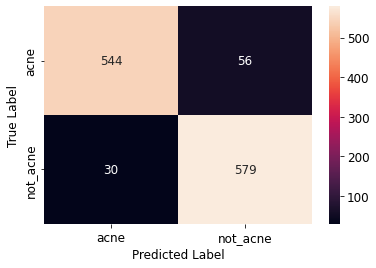

In [157]:
_ = get_performance_based_confidence(df_preds, label_coln= 'label', pred_coln= 'calibrated_predicted',
                                     prob_acne_coln='calibrated_prob_acne', prob_not_acne_coln='calibrated_prob_not_acne', 
                                     acne_confidence = 0.5, not_acne_confidence = 0.5)

test images discarded: 126/1209
              precision    recall  f1-score   support

        acne       0.98      0.90      0.94       501
    not_acne       0.92      0.99      0.95       582

    accuracy                           0.95      1083
   macro avg       0.95      0.94      0.94      1083
weighted avg       0.95      0.95      0.95      1083



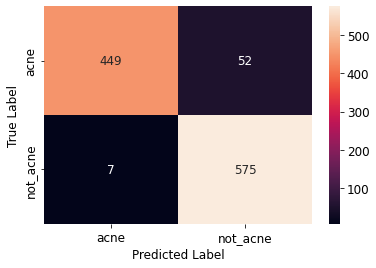

In [158]:
_ = get_performance_based_confidence(df_preds, label_coln= 'label', pred_coln= 'calibrated_predicted',
                                     prob_acne_coln='calibrated_prob_acne', prob_not_acne_coln='calibrated_prob_not_acne', 
                                     acne_confidence = 0.83, not_acne_confidence = 0.55)